# 如何显示误差

**一图胜千言，使用Python的matplotlib库，可以快速创建高质量的图形。**

这是Python数据可视化的系列短篇，针对初级和中级用户，将理论和示例代码相结合，使用matplotlib, seaborn, plotly等工具创建不同主题的图表。该系列教程既可以让初学者快速掌握可视化，也可以作为中级使用者的案头参考，干货满满，赶紧收藏吧。

**本文主题是如何在图表中显示误差。**

In [6]:
import os

import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
plt.style.use("fivethirtyeight")

warnings.filterwarnings("ignore")

## 1. 显示测量误差

科学测量往往存在误差，准确地报告误差跟报告测量结果同样重要。

测量误差（也称为观察误差）是测量值和真实值之间的差异，包括随机误差（任何实验中都会自然发生的误差）和系统误差（由影响所有测量的错误校准的仪器引起）。

举一个例子，假设您正在测量100个学生的体重，有的学生穿较多的衣服，导致重500克，有的学生可能脱水导致轻200克，这些都是测量误差。事实上所有收集的样本都会存在误差，大多数情况下它们不可避免。**所以在数据可视化中，有效显示这些错误可以传达更完整的信息**。

在matplotlib中通过调用ax.errorbar()创建误差图(errorbar)。误差图由一个点和穿过这个点的线段组成，点对应测量结果，线段代表测量误差。

<ErrorbarContainer object of 3 artists>

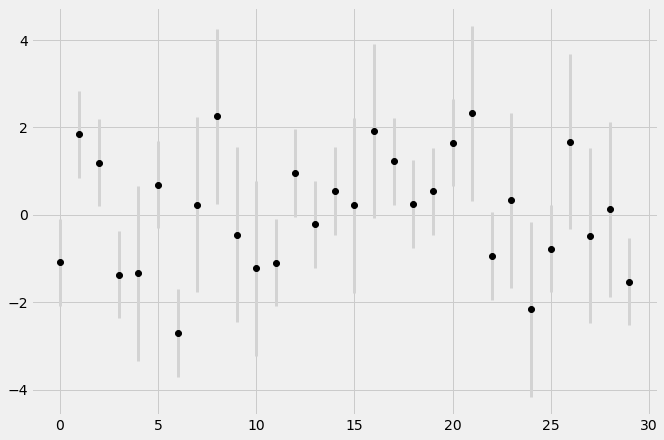

In [4]:
# 设置随机数种子
np.random.seed(123)

# 观测值的数量
n_observations = 30
x = np.arange(n_observations)

# 虚拟测量值
y = np.sin(x) + np.random.randn(n_observations)

# 测量误差，假设误差服从均匀分布
errors = np.random.randint(1, 3, n_observations)

# 调用ax.errorbar接口，提供3个数组，x, y, yerr
# fmt控制点和线段的样式，跟ax.plot的fmt相同
# color: 控制点的颜色
# ecolor: 代表误差的线段的颜色
# elinewidth: 代表误差的线段的大小
fig, ax = plt.subplots(figsize=(10, 7))
ax.errorbar(x, y, yerr=errors, fmt="o", color="black",
            ecolor="lightgray", elinewidth=3)

## 2. 显示预测误差

在机器学习领域，回归模型和时间序列模型用于预测，模型会同时生成预测误差（所谓置信区间），在可视化预测结果时，通常要求显示预测值和预测区间，这可以通过ax.plot()和ax.fill_between()实现。

接下来使用一个真实的案例说明，先从蜂鸟数据获取黄金价格，然后用ARIMA（自回归整合移动平均）预测未来30天的价格，可视化预测结果。

In [5]:
os.environ["TROCHIL_API"] = "fd6ce25fe7c2e980ac31fe2b75a90b1f"

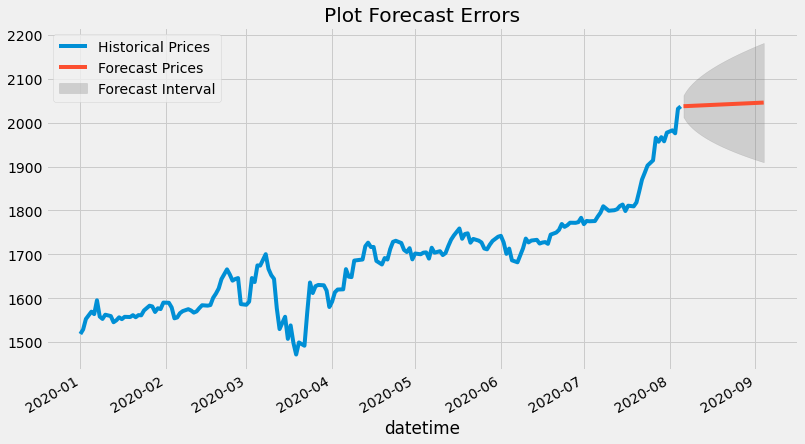

In [8]:
# 从蜂鸟数据下载黄金价格
params = {
    "symbol": "XAUUSD",  # 现货黄金ID
    "start_date": "2010-01-01",
    "end_date": "2020-08-05",
    "apikey": os.getenv("TROCHIL_API")  # 在蜂鸟数据官网注册获取API密钥
}
resp = requests.get("https://api.trochil.cn/v1/forex/history", params)
data = pd.DataFrame.from_records(resp.json()["data"])
data["datetime"] = pd.to_datetime(data["datetime"])
data.set_index("datetime", inplace=True)

# 创建ARMIA模型，预测未来30天价格走势
model = ARIMA(data.close, order=(1, 1, 1))
results = model.fit()
fc, errors, conf = results.forecast(steps=30, alpha=0.05)
fc_df = pd.DataFrame({
    "forecast": fc,
    "lower": conf[:, 0],
    "upper": conf[:, 1]
}, index=pd.date_range("2020-08-06", periods=30))

# 可视化预测结果，包括点预测值和预测区间
# 预测区间包括置信下限和上限，代表真实值可能落入的范围
# 调用ax.plot显示点预测值，ax.fill_between显示预测区间
data_since_2020 = data["2020":]
fig, ax = plt.subplots(figsize=(12, 7))
data_since_2020.close.plot(ax=ax, label="Historical Prices")
ax.plot(fc_df.index, fc_df.forecast, label="Forecast Prices")
ax.fill_between(fc_df.index, fc_df.lower, fc_df.upper, color="gray", alpha=0.3, label="Forecast Interval")
ax.set_title("Plot Forecast Errors")
ax.legend(loc="upper left")